Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE


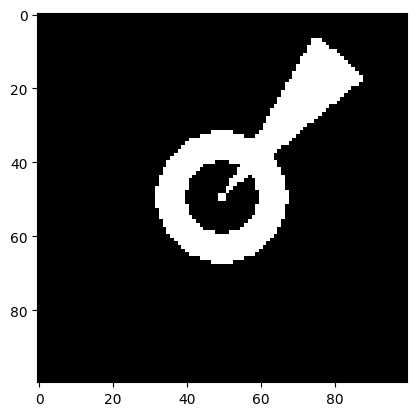

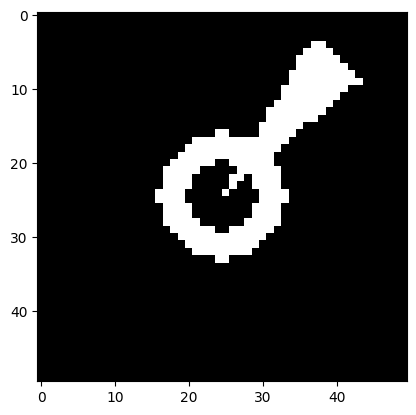

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
opj = os.path.join
import numpy as np
import scipy.io as sio
import tensorflow as tf
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.set_visible_devices([], 'GPU')
from dpu_mini.fs_tools import *
from dpu_mini.mesh_maker import *
from dpu_mini.stats import *
import pandas as pd
import pickle

dm_path = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/code/hypot_code/postproc/aps_pRF.mat'
dm_data = sio.loadmat(dm_path)
dm_in = dm_data['ApFrm']
plt.imshow(dm_in[:,:,51], cmap='gray')
from scipy.ndimage import zoom

og_pix = dm_in.shape[0]
n_pix = 50
pix_ratio = n_pix / og_pix
dm = zoom(dm_in, (pix_ratio, pix_ratio, 1), order=0)  # nearest-neighbor
plt.figure()
plt.imshow(dm[:,:,51], cmap='gray')
# np.save('dm.npy', dm)

# LOAD DATA     

In [2]:
# from dpu_mini.utils import *
# import nibabel as nib
# gii_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/sf2_mcalign/sub-hp01/ses-01'
# gii_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/sf2_coregAFNITOP/sub-hp01/ses-01'
# gii_files = os.listdir(gii_folder)
# gii_files = [f for f in gii_files if '.gii' in f]
# gii_files = [f for f in gii_files if 'SMOOTH' not in f]

# data = {}
# for task in ['pRFLE', 'pRFRE']:
#     t_files = [f for f in gii_files if task in f]
#     hemi_data = {}
#     for hemi in ['L', 'R']:
#         thisf = [f for f in t_files if f'hemi-{hemi}' in f]
#         tdata = []
#         for tgii in thisf:
#             tgii_nib = nib.load(opj(gii_folder, tgii))
#             tgii_data = [i.data for i in tgii_nib.darrays]
#             tgii_data = np.array(tgii_data)[4:,:] # drop first 4 trigger scans             
#             tgii_data = dag_detrending(tgii_data.T, detrend_param=2).T
#             # tgii_data = dag_psc(tgii_data.T).T
#             tdata.append(tgii_data)
#             # break
#         hemi_data[hemi] = np.mean(tdata, axis=0)
#         print(hemi_data[hemi].shape)
#         # tRf = [f for f in t_files if 'hemi-R' in f]
#         # print(tL)   
#     data[task] = pd.DataFrame(np.hstack([
#         hemi_data['L'], hemi_data['R']
#     ]))

# data_full = data.copy()

In [56]:
import os
pyb_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/pybest20/sub-hp01/ses-fprep/denoising'
sub = 'sub-hp01'
fs_dir = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/freesurfer'
pyb_files = os.listdir(pyb_folder)
pyb_files = [p for p in pyb_files if 'bold' in p]
data = {}
for task in ['pRFLE', 'pRFRE']:
    t_files = [f for f in pyb_files if task in f]
    t_files = [f for f in t_files if 'run' in f]
    print(t_files)
    hemi_data = {}
    for hemi in ['L', 'R']:
        thisf = [f for f in t_files if f'hemi-{hemi}' in f]
        tdata = []
        for tnpy in thisf:
            tdata.append(np.load(opj(pyb_folder,tnpy))[4:,:])
        hemi_data[hemi] = np.mean(tdata, axis=0)
        print(hemi_data[hemi].shape)
    data[task] = pd.DataFrame(np.hstack([
        hemi_data['L'], hemi_data['R']
    ]))

data_full = data.copy()

['sub-hp01_ses-fprep_task-pRFLE_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFLE_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFLE_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFLE_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFLE_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFLE_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy']
(348, 139218)
(348, 137925)
['sub-hp01_ses-fprep_task-pRFRE_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFRE_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFRE_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFRE_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFRE_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy', 'sub-hp01_ses-fprep_task-pRFRE_run-3_space-fsn

In [59]:
roi = 'b14_V'
roi_mask = dag_load_roi(sub, roi, fs_dir, combine_matches=True)
data_roi = {}
for k in data.keys():
    data_roi[k] = data_full[k].iloc[:,roi_mask].copy()
data = data_roi.copy()
data['pRFLE'].shape

(348, 30095)

In [60]:
fs_dir = '/Users/marcusdaghlian/projects/dp-clean-link/240522NG/hypot/derivatives/freesurfer'
sub = 'sub-hp01'
# v1 = dag_load_roi(sub, 'b14_V', fs_dir, combine_matches=True)
# v1_ts = data['pRFLE'].iloc[:,v1]

In [61]:
from braincoder.optimize import *
from braincoder.models import GaussianPRF2DWithHRF, ContrastSensitivityWithHRF, DifferenceOfGaussiansPRF2DWithHRF, DivisiveNormalizationGaussianPRF2DWithHRF, CompressiveSpatialGaussiansPRF2DWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

paradigm = np.rollaxis(dm, 2, 0) # time; x ; y
scrn_dist_cm = 34
scrn_diam_cm = 27
angle_rad = 2 * np.arctan(scrn_diam_cm / (2 * scrn_dist_cm))    
# Convert radians to degrees
angle_deg = np.degrees(angle_rad)
radius_deg = angle_deg / 2.0
radius_vert = radius_deg
radius_horiz = radius_deg
print(f'Radius in degrees = {radius_deg:.3f}')
tr = 1.0
x_grid, y_grid = np.meshgrid(
    np.linspace(-radius_horiz, radius_horiz, dm.shape[1]),
    np.linspace(-radius_vert, radius_vert, dm.shape[0])
    )
y_grid *= -1

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

m_list = {
    'gauss' : GaussianPRF2DWithHRF,
    'divn' : DivisiveNormalizationGaussianPRF2DWithHRF,
    'comp' : CompressiveSpatialGaussiansPRF2DWithHRF,
    'diff' : DifferenceOfGaussiansPRF2DWithHRF
}

model = {}
for m in m_list.keys():
    model[m] = m_list[m](
        grid_coordinates, 
        paradigm=paradigm,
        hrf_model=SPMHRFModel(tr=tr), 
        flexible_hrf_parameters=True,
        )
                             

fitter = {}
for task in data.keys():
    fitter[task] = {}
    for m in m_list.keys():
        fitter[task][m] = ParameterFitter(
            model[m], data[task], model[m].paradigm,
            # memory_limit=666666666//10
        ) 
n_steps = 1000


Radius in degrees = 21.656


In [66]:
from dpu_mini.mesh_maker import *
gm = GenMeshMaker(
    sub=sub, fs_dir=fs_dir
)
gm.make_flat_map(
    centre_bool=roi_mask, morph=10, 
)

Using fs dir = /Users/marcusdaghlian/projects/dp-clean-link/240522NG/hypot/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
centering!
Faces with missing vx: 237401
Faces with long edges: 1494
0.1473645270658545
centering!
Faces with missing vx: 234468
Faces with long edges: 1330
0.1500039877322854


Just using undersurface file..


{'cmap': 'viridis', 'vmin': 0.0, 'vmax': 0.0}

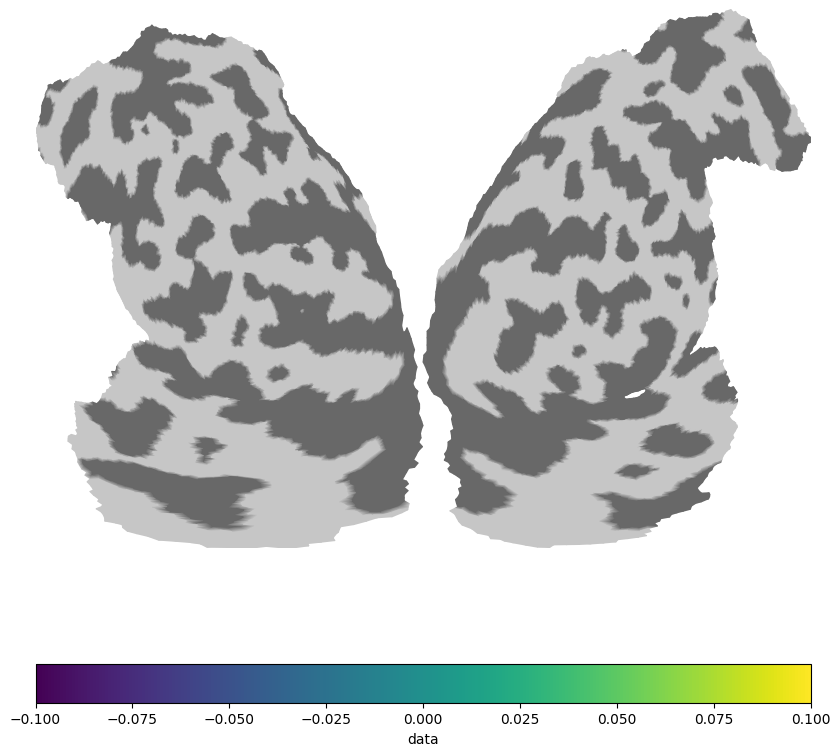

In [67]:
gm.flat_mpl()

# gauss model

In [68]:

bounds       = {
    'x' : [-radius_deg, radius_deg], 
    'y' : [-radius_deg, radius_deg], 
    'sd': [.1, radius_deg*1.5], 
}
grid_points = 20
gr = {}
it = {}
m = 'gauss'
gr[m] = {}
it[m] = {}
for k in data.keys():
    tgp = fitter[k][m].fit_grid(
        x       = np.linspace(bounds['x'][0], bounds['x'][1], grid_points),
        y       = np.linspace(bounds['y'][0], bounds['y'][1], grid_points),
        sd      = np.linspace(bounds['sd'][0], 8, grid_points),
        amplitude   = [1.0],
        baseline    = [0.0],
        use_correlation_cost = True, 
        hrf_delay = [6.0], 
        hrf_dispersion = [1.0],        
    )

    tgp = fitter[k][m].refine_baseline_and_amplitude(tgp)
    tgp['r2'] = fitter[k][m].get_rsq(tgp)
    gr[m][k] = tgp.copy()


Working with chunk size of 63
Using correlation cost!


 99%|█████████▉| 126/127 [00:11<00:00, 11.32it/s]

(1, 348, 62) (32, 62)


100%|██████████| 127/127 [00:12<00:00, 10.11it/s]


(1, 348, 30095) (32, 30095)
Working with chunk size of 63
Using correlation cost!


100%|██████████| 127/127 [00:12<00:00, 10.21it/s]


{'cmap': 'viridis', 'vmin': 0, 'vmax': 1.0}

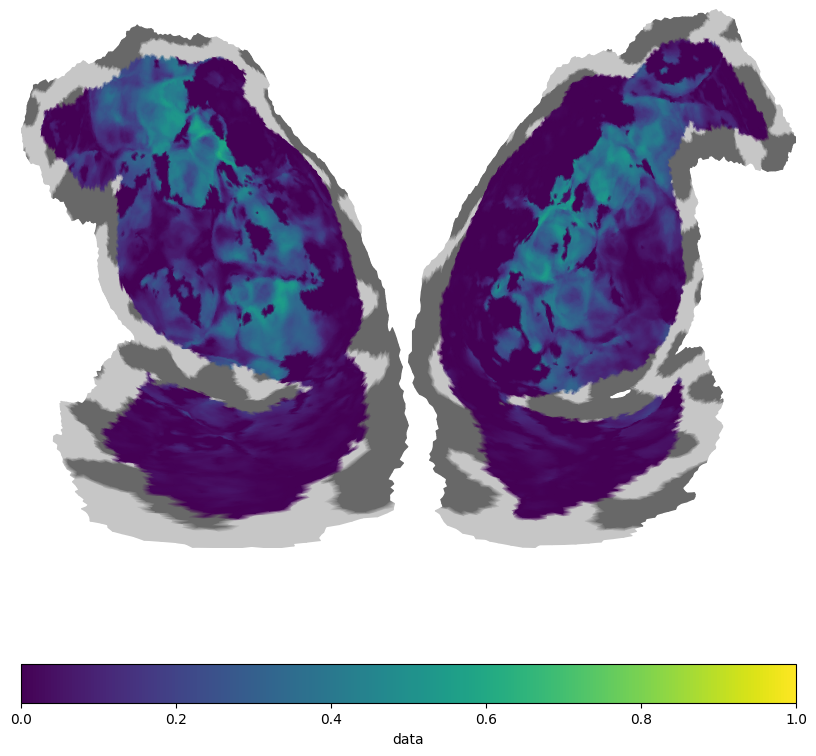

In [81]:
gm.flat_mpl(
    data=gr[m]['pRFRE']['r2'].values, 
    cmap='viridis', vmin=0, vmax=1.0,
    data_sub_mask=roi_mask, 
)

In [ ]:
m = 'gauss'
for k in data.keys():
    tip = fitter[k][m].fit(
        init_pars=tgp, 
        max_n_iterations=1000,  
        learning_rate=0.1
        )
    tip['r2'] = fitter[k][m].get_rsq(tip)
    it[m][k] = tip.copy()

*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 30095


Current R2: 0.21547/Best R2: 0.23104:   7%|▋         | 71/1000 [00:33<06:53,  2.25it/s]

In [39]:
it.keys()

dict_keys(['gauss', 'comp', 'dog', 'diff', 'divn'])

In [ ]:
# m = 'comp'
# it[m] = {}
# for k in data.keys():
#     init_pars = gr['gauss'][k].copy()
#     init_pars['exponent'] = 1.0

#     tip = fitter[k][m].fit(
#         init_pars=init_pars, 
#         max_n_iterations=100,  
#         learning_rate=0.1
#         )
#     tip['r2'] = fitter[k][m].get_rsq(tip)
#     it[m][k] = tip.copy()


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * exponent
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 7591


  0%|          | 0/100 [00:00<?, ?it/s]

(1, 348, 7591) (32, 7591)


Current R2: nan/Best R2: 0.23574: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]   


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * exponent
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 7591


Current R2: nan/Best R2: 0.15425: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]   


In [16]:
m = 'diff'
it[m] = {}
for k in data.keys():
    init_pars = gr['gauss'][k].copy()
    init_pars['srf_amplitude'] = 0.00001
    init_pars['srf_size'] = init_pars['sd'] * 1.5

    tip = fitter[k][m].fit(
        init_pars=init_pars, 
        max_n_iterations=100,  
        learning_rate=0.1
        )
    tip['r2'] = fitter[k][m].get_rsq(tip)
    it[m][k] = tip.copy()


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * srf_amplitude
 * srf_size
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 7591


  0%|          | 0/100 [00:00<?, ?it/s]

(1, 7591, 9) (1, 7591, 5)
(1, 348, 7591) (32, 7591)


Current R2: 0.31883/Best R2: 0.34638: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * srf_amplitude
 * srf_size
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 7591


Current R2: 0.22533/Best R2: 0.24906: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


In [30]:
m = 'divn'
it[m] = {}
for k in data.keys():
    init_pars = gr['gauss'][k].copy()
    init_pars.rename(columns={'amplitude':'rf_amplitude', 'baseline':'bold_baseline'}, inplace=True)
    init_pars['neural_baseline'] = 0.001
    init_pars['surround_baseline'] = 1.0
    init_pars['srf_amplitude'] = 0.00001
    init_pars['srf_size'] = init_pars['sd'] * 1.5

    tip = fitter[k][m].fit(
        init_pars=init_pars, 
        max_n_iterations=100,  
        learning_rate=0.1
        )
    tip['r2'] = fitter[k][m].get_rsq(tip)
    it[m][k] = tip.copy()


*** Fitting: ***
 * x
 * y
 * sd
 * rf_amplitude
 * srf_amplitude
 * srf_size
 * neural_baseline
 * surround_baseline
 * bold_baseline
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 7591


  0%|          | 0/100 [00:00<?, ?it/s]

(1, 348, 7591) (32, 7591)


Current R2: 0.32791/Best R2: 0.34707: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


*** Fitting: ***
 * x
 * y
 * sd
 * rf_amplitude
 * srf_amplitude
 * srf_size
 * neural_baseline
 * surround_baseline
 * bold_baseline
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 7591


Current R2: 0.24471/Best R2: 0.25681: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


In [34]:
data['pRFRE']

source,0,1,8,9,13,20,29,38,120,127,...,276801,276811,276870,276885,276937,277035,277077,277080,277089,277118
0,1.221658,1.230469,0.806925,0.517893,0.043936,-0.289777,0.517678,0.147022,1.096104,1.220605,...,1.548511,0.922217,0.514804,-0.065333,-0.303722,-0.236739,-0.669504,-0.199315,-0.035086,0.302614
1,0.760009,0.944267,1.359792,1.618265,1.321156,0.917054,1.295773,0.204859,-0.143140,-0.025484,...,1.089424,0.982776,1.123404,0.097838,-0.068834,0.032436,-0.369575,-0.939324,0.460606,0.450891
2,0.959403,0.968604,0.166877,-0.076473,-0.781765,-0.755590,-0.355151,-0.236663,0.752441,0.674455,...,1.465403,0.681787,1.153129,0.068681,0.050185,0.158972,0.094914,-0.251245,0.395281,0.512345
3,0.951972,1.218181,0.758978,0.508724,0.123763,0.028629,0.432719,0.084181,0.966705,1.717543,...,1.023616,-1.083277,0.390374,0.394975,-0.061939,0.266244,0.250521,0.339053,0.046834,0.245423
4,0.483397,0.486831,0.093002,0.217937,0.106691,-0.711956,-0.516904,0.684473,0.951438,0.609862,...,0.392536,-0.271093,0.224118,0.625788,0.396670,-0.289426,0.663964,-0.255390,0.116124,1.493063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,-0.461180,-0.438917,0.057296,0.196099,0.135294,0.123407,-0.252857,0.494867,0.350844,-0.038681,...,-0.544232,-0.297514,0.687630,-1.461994,0.704217,0.050990,-0.134021,0.271952,0.000690,-1.994932
344,0.389777,0.321907,-0.014889,-0.234776,-0.412114,0.260626,0.127111,-0.928343,1.060528,0.700950,...,-0.800630,0.207180,0.115050,-0.586461,-0.092299,-0.222633,-0.167883,-0.329026,0.135472,0.664336
345,-0.266545,-0.528421,0.054686,0.030022,0.078739,0.097953,-0.190810,-0.599353,0.022380,-0.414158,...,-1.808225,-0.195190,0.181774,-0.813079,0.436577,0.691302,0.576300,0.018145,0.053462,-0.342040
346,-1.135776,-0.799438,0.194649,0.287611,0.299212,0.164645,-0.156482,-0.799705,-1.080716,-0.918448,...,-1.526678,-0.368757,1.179261,-1.028212,0.353583,-0.485374,-0.157219,0.333735,-0.778012,0.372548


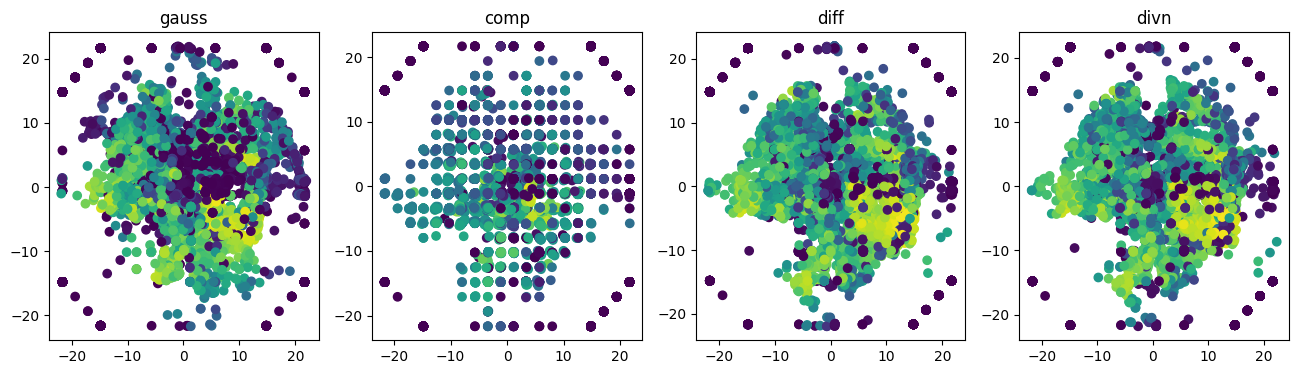

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
axs = axs.flatten()
k = 'pRFLE'
for i,m in enumerate(['gauss', 'comp', 'diff', 'divn']):
    axs[i].scatter(it[m][k]['x'], it[m][k]['y'], c=it[m][k]['r2'], cmap='viridis')
    axs[i].set_title(m)


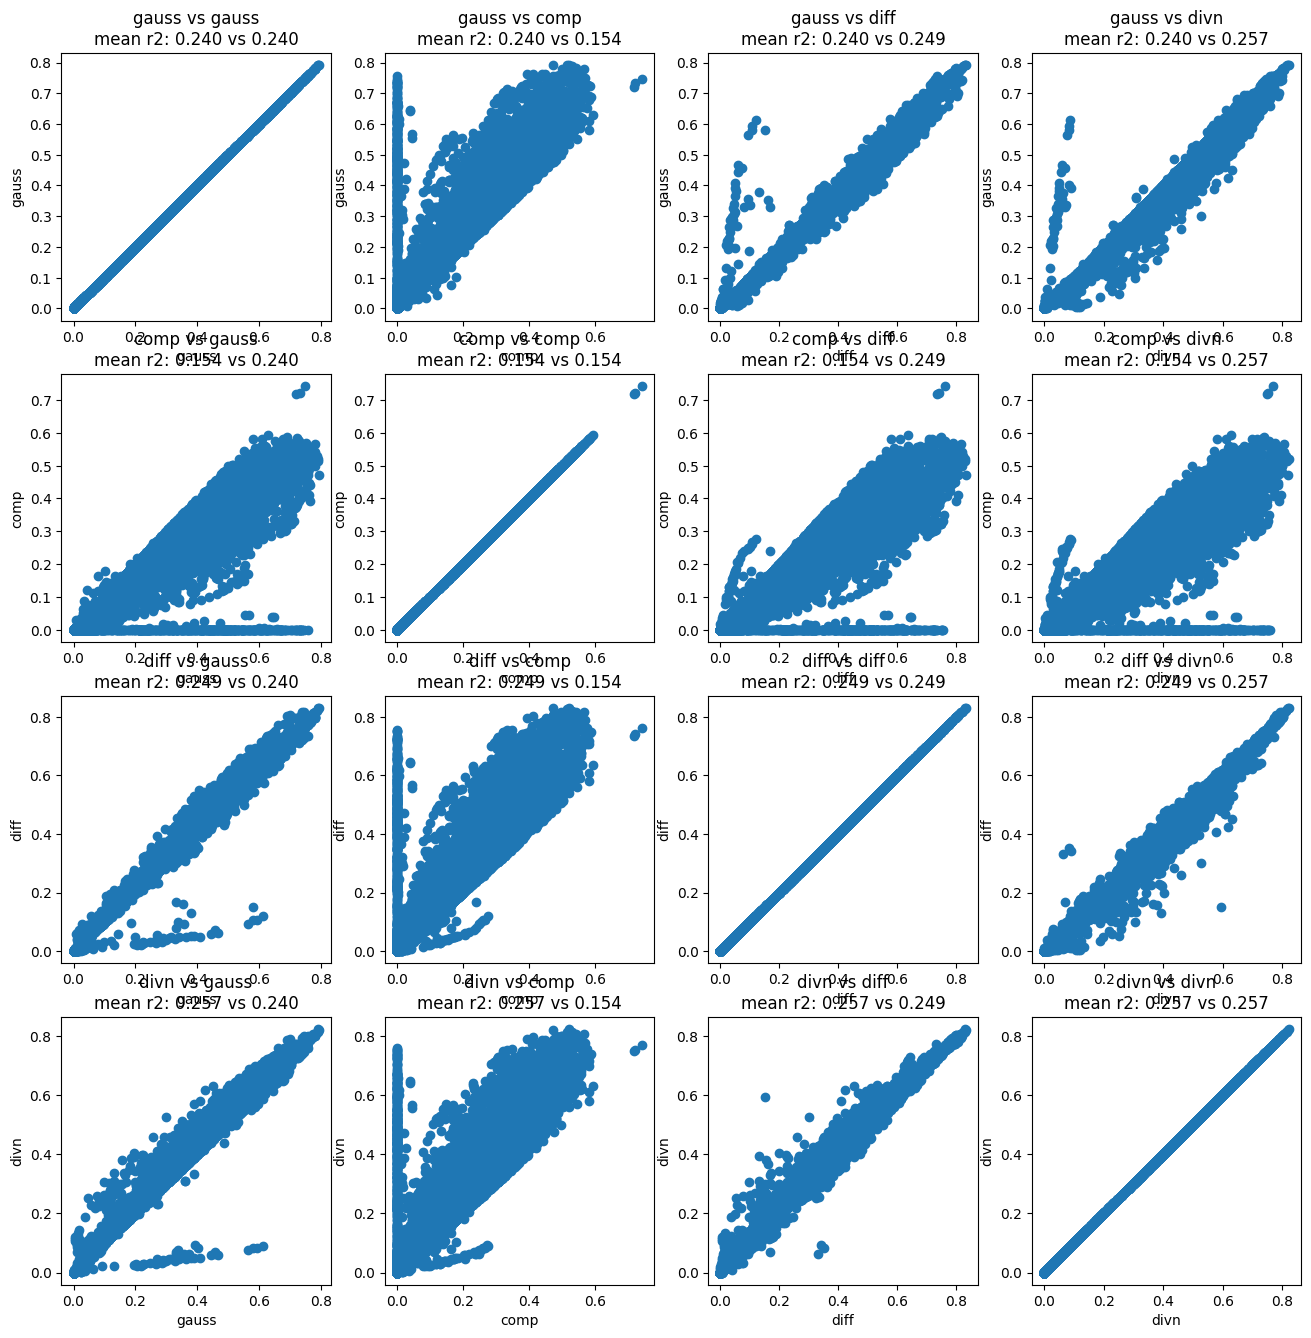

In [49]:
fig, axs = plt.subplots(4, 4, figsize=(16,16))
axs = axs.flatten()
k = 'pRFRE'
i = 0
for i1,m in enumerate(['gauss', 'comp', 'diff', 'divn']):
    for i2,m2 in enumerate(['gauss', 'comp', 'diff', 'divn']):
        axs[i].scatter(it[m2][k]['r2'], it[m][k]['r2'])
        axs[i].set_xlabel(m2)
        axs[i].set_ylabel(m)
        m1r2 = it[m][k]['r2'].mean()
        m2r2 = it[m2][k]['r2'].mean()
        axs[i].set_title(f'{m} vs {m2}\nmean r2: {m1r2:.3f} vs {m2r2:.3f}')
        i += 1

dict_keys(['gauss', 'comp', 'dog', 'diff', 'divn'])

# PRF OBJ

In [ ]:
from prf_obj import *
prf_objs = []
prf_ids = []
for k in data.keys():
    prf_objs.append(PrfObj(
        pd_params=iter[k], 
        bcoder_model=model, 
        data=data[k], 
        model='gauss', 
    )
    )
    prf_ids.append(k)
po = PrfMulti(prf_objs, prf_ids)

In [ ]:
po.add_prf_diff('pRFLE', 'pRFRE')

In [ ]:
%matplotlib inline
a =po.po['pRFLE'].prf_plotter(62, do_str=True)
plt.show()
plt.figure()

# Surface plotting

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dpu_mini.mesh_dash import dag_mesh_pickle, MeshDash

In [ ]:
sub = 'sub-hp01'
fs_dir = '/Users/marcusdaghlian/projects/dp-clean-link/240522NG/hypot/derivatives/freesurfer'
fs = MeshDash(
    sub, 
    fs_dir=fs_dir,
    output_dir='z_dash',
    )
fs.web_get_ready()
for k in po.pd_params.keys():
    col_kwargs = {
    }
    if 'pol' in k:
        col_kwargs['vmin'] = -np.pi
        col_kwargs['vmax'] = np.pi
        col_kwargs['cmap'] = 'marco_pol'
    elif 'ecc' in k:
        col_kwargs['vmin'] = 0
        col_kwargs['vmax'] = radius_deg
        col_kwargs['cmap'] = 'jet'
    elif 'r2' in k:
        col_kwargs['vmin'] = 0
        col_kwargs['vmax'] = 1.0
        col_kwargs['cmap'] = 'plasma'
    elif ('x' in k) or ('y' in k):
        col_kwargs['vmin'] = -10
        col_kwargs['vmax'] = 10
        col_kwargs['cmap'] = 'RdBu_r'
    ktask = k.split('-')[0]
    fs.web_add_vx_col(
        data=po.pd_params[k],
        data4mask=po.pd_params[f'{ktask}-r2'],
        vx_col_name=k.replace('-','_'), 
        rsq_thresh=0.1, 
        **col_kwargs
    )

for k in po.po['diff_pRFLE_pRFRE'].pd_params.keys():
    fs.web_add_vx_col(
        data=po.po['diff_pRFLE_pRFRE'].pd_params[f'{k}'],
        # data4mask=,
        vx_col_name=f"diff_{k.replace('-','_')}", 
        cmap='RdBu_r',
        # **col_kwargs
    )
# Other cool things....
# you can add ROIs

# fs.web_add_roi(roi_list='V1')
roi_list = dag_roi_list_expand(sub, 'b14_', fs_dir)[1:]
fs.web_add_roi(roi_list=roi_list)
# You can also add conditional functions to do plotting. 
# For example if you have a function to plot the timeseries put that here 
def my_plot_function(vertex_id):
    fig = plt.figure()
    
    # Do some plotting based on the vertex...
    return fig

# We have already made one here -> 

fs.web_add_mpl_fig_maker(
    mpl_func=po.po['pRFLE'].prf_plotter, # my_plot_function
    mpl_key='pRFLE',
    mpl_kwargs={'do_str':True},
) # you can add more than one...
fs.web_add_mpl_fig_maker(
    mpl_func=po.po['pRFRE'].prf_plotter, # my_plot_function
    mpl_key='pRFRE',
    mpl_kwargs={'do_str':True},
)
# Other cool things....
# you can add ROIs
# fs.web_add_roi(roi_list='V1')

# We have already made one here -> 


In [ ]:
app = fs.web_launch_with_dash() # change to exciting to use silly fonts...
# Open the app in a browser (or in the notebook)
app.run(mode='external', host='127.0.0.1', port=8001, debug=False, use_reloader=False) 
# Go to localhost:8000 in your browser to see the app.

In [ ]:
po.pd_params.keys()

In [ ]:
# Compare Left & Right 
# [1] ecc 
roi_list = ['V1', 'V2', 'V3.',] # 'hV4', "LO", "VO"]
fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-ecc', 'pRFRE-ecc', 
        th={
            'all-min-r2':.1, 
            'all-max-ecc' : 20.0,
            'roi': mask, 
        }, 
        ax=axs[ir], do_corr=True, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(0,20)
    axs[ir].set_ylim(0,20)

fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-pol', 'pRFRE-pol', 
        th={
            'all-min-r2':.1, 
            'all-max-ecc' : 20.0,
            'roi': mask, 

        }, 
        ax=axs[ir], do_corr=False, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(-np.pi,np.pi)
    axs[ir].set_ylim(-np.pi,np.pi)



fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-sd', 'pRFRE-sd', 
        th={
            'all-min-r2':.1, 
            'all-max-ecc' : 20.0,
            'roi': mask, 

        }, 
        ax=axs[ir], do_corr=True, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(0,10)
    axs[ir].set_ylim(0,10)



fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-r2', 'pRFRE-r2', 
        th={
            'roi': mask, 

        }, 
        ax=axs[ir], do_corr=True, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(0,1)
    axs[ir].set_ylim(0,1)


In [ ]:

bounds       = {
    'x' : [-20, 20], 
    'y' : [-20, 20], 
    'sd': [.1, 10], 

    # ''
}
grid_points = 20

# default delay=6, disp = 1.
# min_hrf_delay=3., max_hrf_delay=7.0,
#              min_dispersion=0.3, max_dispersion=2.0):
# hrf_kwargs = {
#     'hrf_delay' : np.linspace(3.1,6.5,5), # np.array([1.0]), 
#     'hrf_dispersion' :np.array([1.0]), # np.linspace(0.4,1.9,5), #np.array([1.0]), 
# }
grid_pars = cfitter.fit_grid(
    x       = np.linspace(bounds['x'][0], bounds['x'][1], 20),
    y       = np.linspace(bounds['y'][0], bounds['y'][1], 20),
    sd      = np.linspace(bounds['sd'][0], bounds['sd'][1], 10),
    amplitude   = [1.0],
    baseline    = [0.0],
    use_correlation_cost = True, 
    # **hrf_kwargs
    
)
grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars, ) #l2_alpha=1.0) 
grid_preds = cfitter.get_predictions(parameters=grid_pars)

r2 = cfitter.get_rsq(parameters=grid_pars)
print(r2.mean())
print(r2.max())

In [ ]:
plt.plot(grid_preds.iloc[:,r2.argmax()])
plt.plot(v1_ts.iloc[:,r2.argmax()])

In [ ]:
ecc, pol = dag_coord_convert(
    grid_pars['x'], grid_pars['y'], 'pol2cart'
)

In [ ]:
iter_pars = cfitter.fit(
    init_pars=grid_pars, 
    learning_rate=0.01,
    max_n_iterations=500,
)

In [ ]:
r2 = cfitter.get_rsq(parameters=grid_pars)
r2_mask = (r2>0.3).to_numpy()
plt.scatter(
    grid_pars['x'].iloc[r2_mask], 
    grid_pars['y'].iloc[r2_mask],
    c=r2.iloc[r2_mask], 
)

In [ ]:
r2

In [ ]:
(r2>0.1).sum()

In [ ]:
from dpu_mini.mesh_maker import *
m = GenMeshMaker(
    sub='sub-hp01', fs_dir=fs_dir,
)

In [ ]:
for k in data.keys():
    ecc,pol = dag_coord_convert(
        gp[k]['x'], gp[k]['y'], 
        'cart2pol'
    )
    tmask = (gp[k]['r2']>0.1).to_numpy()
    tmask &= (ecc<22.0).to_numpy()
    m.add_surface(
        data=ecc, 
        data_mask=tmask, 
        vmin=0.0, vmax=20.0, cmap='jet',
        surf_name=f'ecc_{k}'
    )
    m.add_surface(
        data=pol, 
        data_mask=tmask, 
        vmin=-np.pi, vmax=np.pi, cmap='marco_pol',
        surf_name=f'pol_{k}'
    )
    m.add_surface(
        data=gp[k]['r2'], 
        data_mask=tmask, 
        vmin=0, vmax=1.0, cmap='viridis',
        surf_name=f'r2_{k}'
    )
    
    plt.figure()
    m.flat_mpl(
        data=ecc, 
        data_mask=tmask, 
        vmin=0.0, vmax=20.0, cmap='jet'
    )
    plt.figure()
    m.flat_mpl(
        data=pol, 
        data_mask=tmask, 
        # vmin=-np.pi, vmax=20.0, 
        cmap='marco_pol'
    )
    # print(ecc)
    # m.add_surface(
    #     data=gp[k][]
    # )

In [ ]:
m.open_fs_surface(m.surf_list)

In [ ]:
m.surf_list

In [ ]:
sub = 'sub-hp01'
cb = dag_load_roi(sub, 'b14_V', fs_dir, combine_matches=True)

m.make_flat_map(centre_bool=cb)

In [ ]:
m.flat_mpl(
    data=ecc, 
    vmin=0.0, vmax=20.0, 
    data_sub_mask=v1, 
    data_mask=r2>0.1, 
)
plt.figure()
m.flat_mpl(
    data=pol, 
    vmin=-np.pi, vmax=np.pi, cmap='marco_pol',
    data_sub_mask=v1, 
    data_mask=r2>0.1, 
    
)

In [ ]:
m.flat_mpl(
    data=r2, 
    vmin=0, vmax=1.0, cmap='jet',
    data_sub_mask=v1, 
    data_mask=r2>0.1, 
)

In [ ]:
r2

In [ ]:
!pip install scikit-learn 

In [ ]:
    grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars)    
    r2 = cfitter.get_rsq(parameters=grid_pars)
    pkl2save = {
        'config' : config, 
        'pars' : grid_pars, 
        'stage' : 'grid', 
        'r2' : r2, 
        'name' : grid_out.split('/')[-1],            
        'data' : script_start_time, 
        'script' : current_script, 
        'script_str' : script_str,
    }
    with open(grid_out, 'wb') as file:
        pickle.dump(pkl2save, file)
else:
    print(grid_out_all)
    try: 
        with open(grid_out_all, 'rb') as file:
            grid_pars_full = pickle.load(file)['pars']
            grid_pars = grid_pars_full.iloc[roi_mask,:]
    except:
        with open(grid_out, 'rb') as file:
            grid_pars = pickle.load(file)['pars']
if grid_only:
    print('ONLY RUNNING GRID STAGE')
    sys.exit()
print(psc_ts_mask.shape)
print(psc_ts_mask)
# Iterative stage         
iter_out = opj(output_path, f'{sub}_ses-{eye}_task-pRF_model-gauss_stage-iter_roi-{roi}{id}.pkl')
if (not os.path.exists(iter_out)) | ow:
    if fit_hrf:
        grid_pars['hrf_delay'] = 6.0
        grid_pars['hrf_dispersion'] = 1.0
    # grid_pars to float 16 
    grid_pars = grid_pars.astype(np.float16)
    iter_pars = cfitter.fit(
        init_pars=grid_pars, 
        max_n_iterations=config['gauss']['num_steps'], 
        fixed_pars=config['gauss']['fixed_pars'],
        )        
    r2 = cfitter.get_rsq(parameters=iter_pars)
    pkl2save = {
        'config' : config, 
        'pars' : iter_pars, 
        'stage' : 'iter', 
        'r2' : r2, 
        'name' : iter_out.split('/')[-1],            
        'data' : script_start_time, 
        'script' : current_script, 
        'script_str' : script_str,
    }
    with open(iter_out, 'wb') as file:
        pickle.dump(pkl2save, file)

In [ ]:
!pip install nibabel

In [ ]:
pars = {
    'x' : np.array([-5,5,3]),
    'y' : np.array([-5,5,3]), 
    'sd' : np.array([1,1,2]),
    'baseline' : np.array([0.0, 0.0, 0.0, ]), 
    'amplitude' : np.array([10, 10, 10, ]),
}
import pandas as pd 
pars = pd.DataFrame(pars)
pars
a = model.predict(parameters=pars)
plt.plot(a.iloc[:,0])
plt.plot(a.iloc[:,1])